# data processing

In [2]:
#이미지 데이터 경로 설정
image_dir = Path('image data/train data')
#이미지 경로 및 라벨링, 데이터셋화
filepaths = list(image_dir.glob(r'**/*.jpeg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
#경로와 라벨 결합
train_df = pd.concat([filepaths, labels], axis=1)
#이미지 데이터 경로 설정
image_dir = Path('image data/test data')
#이미지 경로 및 라벨링, 데이터셋화
filepaths = list(image_dir.glob(r'**/*.jpeg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
#경로와 라벨 결합
test_df = pd.concat([filepaths, labels], axis=1)

In [3]:
#데이터세트 만들기 위한 생성기 정의
#훈련 데이터가 적어 과대적합이 일어날 수 있기 때문에 여러 랜덤한 변환을 적용하여 샘플을 늘림
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2, #검증 데이터 비율
    width_shift_range=0.2, #수평 이동
    height_shift_range=0.2, #수직 이동
    shear_range=0.2, #전단 적용
    horizontal_flip=True, #수평으로 뒤집기
    fill_mode='nearest' #픽셀 채우기
)
#데이터 증식은 훈련데이터에만 적용
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [4]:
#앞서 만든 데이터세트 생성기로 데이터세트 생성
#훈련, 검증 데이터에 데이터 증식 및 전처리 적용(ex.픽셀 맞춤, 배치)
#테스트 데이터세트 생성
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    batch_size=len(train_df['Label']),
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=len(train_df['Label']),
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=len(test_df['Label']),
    shuffle=False
)

Found 172 validated image filenames belonging to 6 classes.


Found 42 validated image filenames belonging to 6 classes.
Found 93 validated image filenames belonging to 6 classes.


# YOLO

In [5]:
#객체 탐지 모델 불러오기
model_yolo = YOLO('best_final.pt')

In [6]:
#앞서 만든 데이터세트별로 객체 탐지 결과 저장
results_train = model_yolo.predict(source=train_images.filepaths, save=True)
results_val = model_yolo.predict(source=val_images.filepaths, save=True)
results_test = model_yolo.predict(source=test_images.filepaths, save=True)
results_lst=[results_train,results_val,results_test]


0: 416x416 1 excavator, 4 piles, 1: 416x416 1 excavator, 2: 416x416 1 excavator, 3: 416x416 1 excavator, 4: 416x416 1 excavator, 1 plant, 5: 416x416 1 basin, 1 brick, 1 excavator, 1 mixed, 1 steel, 6: 416x416 1 dump truck, 1 excavator, 7: 416x416 1 excavator, 8: 416x416 1 excavator, 9: 416x416 1 excavator, 2 plants, 10: 416x416 1 excavator, 11: 416x416 1 pile, 14 steels, 12: 416x416 1 excavator, 13: 416x416 1 excavator, 14: 416x416 2 piles, 15: 416x416 1 pile, 16: 416x416 1 pile, 17: 416x416 2 piles, 1 plant, 18: 416x416 1 pile, 19: 416x416 (no detections), 20: 416x416 1 pile, 21: 416x416 2 piles, 22: 416x416 1 excavator, 1 pile, 23: 416x416 1 excavator, 1 pile, 24: 416x416 3 piles, 1 plant, 9 steels, 25: 416x416 1 dump truck, 3 piles, 26: 416x416 2 piles, 27: 416x416 1 plant, 28: 416x416 17 plants, 29: 416x416 1 excavator, 8 plants, 30: 416x416 4 plants, 31: 416x416 21 plants, 32: 416x416 5 plants, 33: 416x416 4 plants, 1 plastic barrel, 12 woods, 34: 416x416 3 plants, 35: 416x416 6 

In [7]:
#탐지된 객체를 대분류로 묶기 위한 변수 설정
truck=['dump truck', 'mixed']
plastering_tool=['Trowel', 'rainboot', 'plasterer shoe']
brick=['brick','bricks']
concrete=['concrete bag', 'basin']
liquid_material=['plastic barrel', 'square can']
merge_lst=[truck, plastering_tool, brick, concrete, liquid_material]
merge_lst_name=['truck', 'plastering_tool', 'brick', 'concrete', 'liquid_material']

In [9]:
#객체 탐지 결과에서 객체에 대한 정보 추출
#면적(area)에 대한 정보는 사용하지 않았기 때문에 신경쓰지 않아도 됨

#클래스 이름 나열
class_name=[]
for i in range (len(model_yolo.names)):
  class_name.append(model_yolo.names[i])

#results는 train or valid or test 데이터세트
for results in results_lst:
  #클래스 개수
  lst=[]
  #result는 사진 한장 한장
  for result in results:
    area_tensor=[]
    for i in range (len(result.boxes.cls)):
      area=result.boxes.xywh[i,2]*result.boxes.xywh[i,3]
      area=area.cpu().numpy().tolist()
      area_tensor.append(area)
    area_tensor = tf.convert_to_tensor(area_tensor)
    merged_tensor = np.vstack((result.boxes.cls.cpu(), area_tensor))
    lst.append(merged_tensor)
    #lst[i]는 사진 한장의 클래스와 면적에 대한 array
  #클래스 별 개수
  lst_final=[]
  lst_flat=[]
  #사진 한장 한장 반복문 실행
  for num1 in range (len(results)):
    #class_info는 클래스 개수를 저장하는 딕셔너리
    class_info = {}

    #탐지된 객체 하나씩 반복하면서 정보 저장
    #lst[result][0]는 클래스 정보
    for cls, area in zip(lst[num1][0], lst[num1][1]):
        #탐지된 클래스에 대한 정보가 저장되어있지 않다면 Count:0으로 만들고 개수 추가
        if cls not in class_info:
            class_info[cls] = {
                'Count': 0
            }
        class_info[cls]['Count'] += 1

    #탐지된 클래스 외의 클래스들은 개수를 0으로 설정
    for cls in range(0,len(model_yolo.names)):
        if cls not in class_info:
            class_info[cls] = {
                'Count': 0
            }

    #앞서 추출된 클래스의 개수 정보들을 데이터프레임 형태로 변환
    df = pd.DataFrame(class_info).T.reset_index().rename(columns={'index': 'Class'})
    #클래스 값으로 정렬
    df = df.sort_values('Class')
    df['Class_name'] = class_name
    df['Count'].reset_index(drop=True)
    df = df.reset_index(drop=True)
    #소분류의 클래스들을 대분류의 클래스로 객체 병합
    for num2 in merge_lst:
      count=0
      for num3 in num2:
        count += df['Count'][df.loc[df['Class_name'] == num3].index[0]]
        df = df.drop(df.loc[df['Class_name'] == num3].index[0])
      new_row = pd.DataFrame([{'Class': len(df), 'Count': count, 'Class_name': merge_lst_name[merge_lst.index(num2)]}])
      df = pd.concat([df, new_row], ignore_index=True)
    df = df.sort_values('Class_name')
    
    #데이터프레임->텐서
    tensor1 = tf.convert_to_tensor(df['Count'].reset_index(drop=True), dtype=tf.float32)
    flatten_tensor = tf.reshape(tensor1, [-1])
    lst_final.append(tensor1)
    lst_flat.append(flatten_tensor)
  if results==results_train:
    lst_train=lst_final
  elif results==results_val:
    lst_val=lst_final
  elif results==results_test:
    lst_test=lst_final

# tfidf

In [10]:
#만들어진 tfidf 파일 불러오기, 텐서화
tfidf=pd.read_csv('final_tfidf.csv', encoding='utf-8-sig', index_col=0)
tfidf_tensor = tf.convert_to_tensor(tfidf)

# merge

In [11]:
#앞서 만들어진 객체 정보의 텐서 불러오기
lst=[lst_train,lst_val,lst_test]

In [12]:
#개수 0인 객체는 tfidf점수는 0
lst_train_merge=[]
lst_val_merge=[]
lst_test_merge=[]
for lst_1 in lst:
  for result in range (len(lst_1)):
    var = tf.Variable(tfidf_tensor)
    for cls in range(0,len(tfidf.columns)):
      if lst_1[result][cls]==0:
        for i in range (6):
          var[i,cls].assign(0)
    #1행 개수, 2~7행 tfidf
    merged_tensor2 = np.vstack((lst_1[result], var))
    if lst_1==lst_train:
      lst_train_merge.append(merged_tensor2)
    elif lst_1==lst_val:
      lst_val_merge.append(merged_tensor2)
    elif lst_1==lst_test:
      lst_test_merge.append(merged_tensor2)

In [13]:
lst_merge=[lst_train_merge,lst_val_merge,lst_test_merge]

In [ ]:
merged_tensor2

array([[          0,           0,           0,           0,           0,           1,           0,           0,           2,           0,           0,           1,           0,           0],
       [          0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0,           0,           0,           0,           0,           0,      0.1426,           0,           0],
       [          0,           0,           0,           0,           0,     0.17093,           0,           0,     0.31204,           0,           0,           0,           0,           0],
       [          0,           0,           0

In [14]:
#개수*tfidf
lst_train_final=[]
lst_val_final=[]
lst_test_final=[]
for lst in lst_merge:
  for n in range (len(lst)):
    for i in range (1,len(lst[0])):
      for k in range (len(tfidf.columns)):
        #1행의 개수 * 그 아래의 각각의 tfidf
        lst[n][i][k]=lst[n][0][k]*lst[n][i][k]
    #1번째 행의 개수는 이제 필요 없으니 1번째 행 삭제
    tensor = np.delete(lst[n], [0], axis=0)
    #데이터세트 별로 텐서화
    if lst==lst_train_merge:
      lst_train_final.append(tensor.reshape(-1))
    elif lst==lst_val_merge:
      lst_val_final.append(tensor.reshape(-1))
    elif lst==lst_test_merge:
      lst_test_final.append(tensor.reshape(-1))

In [15]:
#사진과 공종 종류
images_train, labels_train = next(train_images)
images_val, labels_val = next(val_images)
images_test, labels_test = next(test_images)

In [16]:
#앞서 만든 개수*tfidf 텐서
object_train =np.array(lst_train_final)
object_test =np.array(lst_test_final)
object_val =np.array(lst_val_final)

# 기존 모델

In [17]:
#모바일넷 프레임워크 불러오기
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [27]:
#인풋 레이어 설정
inputs = pretrained_model.input
#드롭아웃&덴스 레이어 설정
dropout = tf.keras.layers.Dropout(rate=0.2)(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(dropout)
x = tf.keras.layers.Dense(128, activation='relu')(x)
#마지막 레이어 설정(각 공종 별로 확률값을 나타나게 됨)
#이후 확률값이 가장 큰 값을 결과값으로 선택
outputs = tf.keras.layers.Dense(6, activation='softmax')(x) #softmax is the activation function for classiciation task

model_org = tf.keras.Model(inputs=inputs, outputs=outputs)

model_org.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#모델 구조 확인
model_org.summary()

In [ ]:
#학습 변수 설정
callback = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
checkpointer = ModelCheckpoint(filepath="weights_org1.hdf5", verbose=1, save_best_only=True)

history_org = model_org.fit(x=images_train,
    y=labels_train,
    validation_data = (images_val, labels_val),
    epochs=40,
    batch_size=8,
    callbacks=[
        callback
    ]
)

In [30]:
#기존에 학습한 모델 불러오기
model_org.load_weights('weight_org.hdf5')

In [ ]:
#학습과정에서 정확도 변화 시각화
pd.DataFrame(history_org.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [ ]:
#학습과정에서 로스값 변화 시각화
pd.DataFrame(history_org.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
#테스트 데이터에서 학습한 모델 평가
results_org = model_org.evaluate(images_test, labels_test, verbose=0)

print("    Test Loss: {:.5f}".format(results_org[0]))
print("Test Accuracy: {:.2f}%".format(results_org[1] * 100))

In [24]:
#테스트 데이터 추론
pred_org = model_org.predict(images_test)
pred_org_final = np.argmax(pred_org,axis=1)

#추론한 결과(공종별 확률값)를 라벨로 변환(확률값 중 가장 큰 값)
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_org_final = [labels[k] for k in pred_org_final]

# Display the result
print(f'The first 5 predictions: {pred_org_final[:5]}')

3/3 [==============================] - 1s 268ms/step
The first 5 predictions: ['carpentry', 'carpentry', 'masonry', 'carpentry', 'carpentry']


In [25]:
#테스트 데이터에서 실제값이 landscaping인 사진들의 추론 결과값(공종별 확률)
pred_org[[index for index, label in enumerate(labels_test) if np.array_equal(label, np.array([0, 0, 1, 0, 0, 0]))]]

array([[ 0.00065917,     0.47874,     0.51857,  0.00076172,  5.3606e-05,    0.001211],
       [ 0.00074776,     0.62091,     0.35035,   0.0017384,  0.00058413,    0.025672],
       [  6.925e-06,   0.0051969,     0.98524,   0.0015767,  0.00027434,   0.0077075],
       [ 0.00097892,     0.20975,     0.66966,     0.10541,   0.0017994,    0.012395],
       [ 0.00043098,     0.12602,     0.86855,  0.00084161,  9.8225e-05,   0.0040566],
       [  0.0011254,     0.94952,    0.040847,     0.00678,   0.0005434,   0.0011817],
       [ 0.00022052,      0.0442,     0.87072,    0.022448,   0.0014184,    0.060994],
       [ 0.00019543,     0.91939,    0.077441,  0.00028785,  0.00013543,   0.0025501],
       [ 2.7987e-05,    0.020384,     0.97197,   0.0036227,  0.00013443,   0.0038604],
       [ 0.00027785,     0.48776,     0.50695,   0.0022356,  0.00012124,   0.0026532],
       [ 6.2452e-05,    0.014855,       0.967,   0.0015499,  0.00040549,    0.016127],
       [ 0.00020175,    0.010034,     0.976

In [26]:
#평가지표 확인
from sklearn.metrics import confusion_matrix, classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred_org_final))

              precision    recall  f1-score   support

   carpentry       0.92      0.67      0.77        18
   earthwork       0.84      0.94      0.89        17
 landscaping       0.93      0.81      0.87        16
     masonry       0.67      0.93      0.78        15
    painting       0.83      0.36      0.50        14
  plastering       0.50      0.77      0.61        13

    accuracy                           0.75        93
   macro avg       0.78      0.75      0.74        93
weighted avg       0.80      0.75      0.75        93



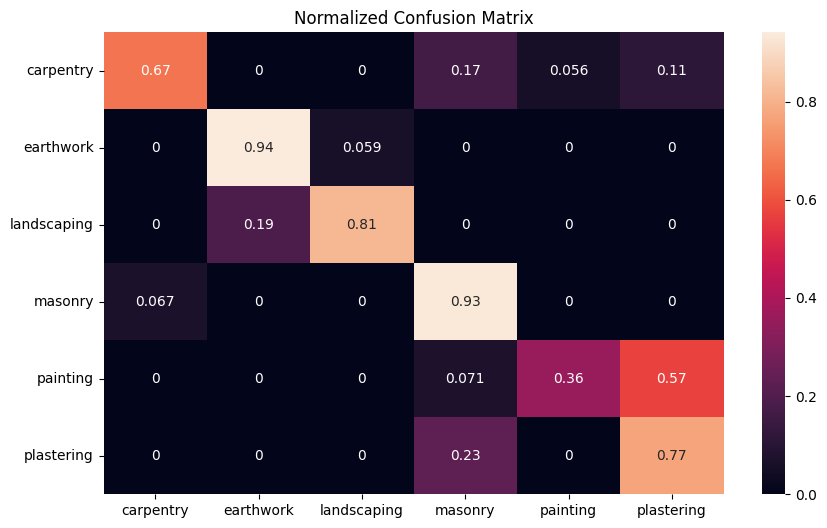

In [27]:
#혼동행렬 확인
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred_org_final, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
#학습한 모델 저장
model_org.save(filepath='weight_org.hdf5')

# 연구 모델

In [23]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [24]:
#연구 모델을 입력값이 2개가 됨
#1280+84
image_input = pretrained_model.input #이미지에 대한 인풋값
object_input = Input(shape=(84,))#lst_merge[0].input #객체 탐지, 표준시방서 데이터(84,)
#이미지에 대한 인풋이 모바일넷 프레임워크를 지난 후 나온 텐서에 객체에 대한 인풋을 결합
output1 = tf.keras.layers.Concatenate(axis=1)([pretrained_model.output, object_input]) #(1280+84,)
dropout = tf.keras.layers.Dropout(rate=0.2)(output1)

x = tf.keras.layers.Dense(128, activation='relu')(dropout)
x = tf.keras.layers.Dense(128, activation='relu')(x) #relu is the activation function for neurla network task
output = tf.keras.layers.Dense(6, activation='softmax')(x) #softmax is the activation function for classiciation task

model = tf.keras.Model(inputs=[image_input, object_input], outputs=output)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )

checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

history = model.fit(x=[images_train, object_train],
    y=labels_train,
    validation_data = ([images_val, object_val], labels_val),
    epochs=20,
    batch_size=8,
    callbacks=[
        callback
    ]
)

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [30]:
model.load_weights('weight.hdf5')

In [ ]:
model.save(filepath='weight.hdf5')

In [31]:
results = model.evaluate([images_test, object_test], labels_test, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.59618
Test Accuracy: 80.65%


In [32]:
# Predict the label of the test_images
pred = model.predict([images_test, object_test])
pred_final = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_final = [labels[k] for k in pred_final]

# Display the result
print(f'The first 5 predictions: {pred_final[:5]}')

3/3 [==============================] - 2s 290ms/step
The first 5 predictions: ['carpentry', 'carpentry', 'carpentry', 'carpentry', 'carpentry']


In [33]:
from sklearn.metrics import confusion_matrix, classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred_final))

              precision    recall  f1-score   support

   carpentry       0.94      0.89      0.91        18
   earthwork       0.79      0.88      0.83        17
 landscaping       0.86      0.75      0.80        16
     masonry       0.92      0.80      0.86        15
    painting       0.73      0.57      0.64        14
  plastering       0.63      0.92      0.75        13

    accuracy                           0.81        93
   macro avg       0.81      0.80      0.80        93
weighted avg       0.82      0.81      0.81        93



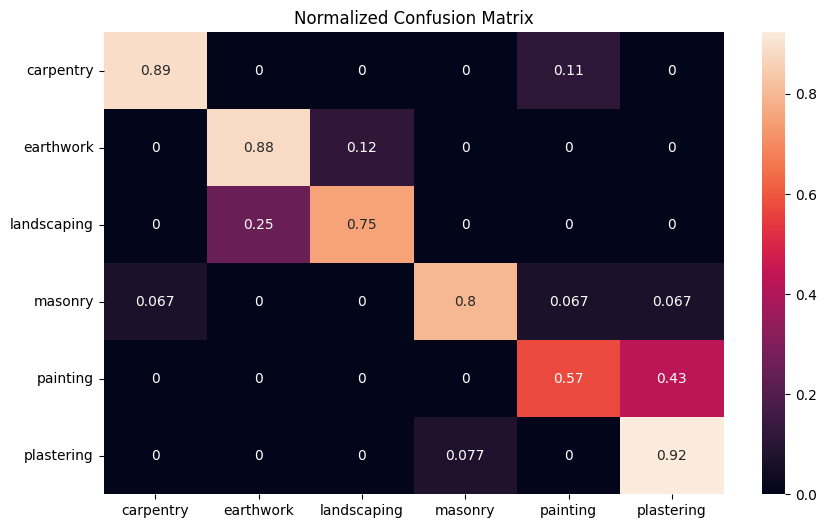

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred_final, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

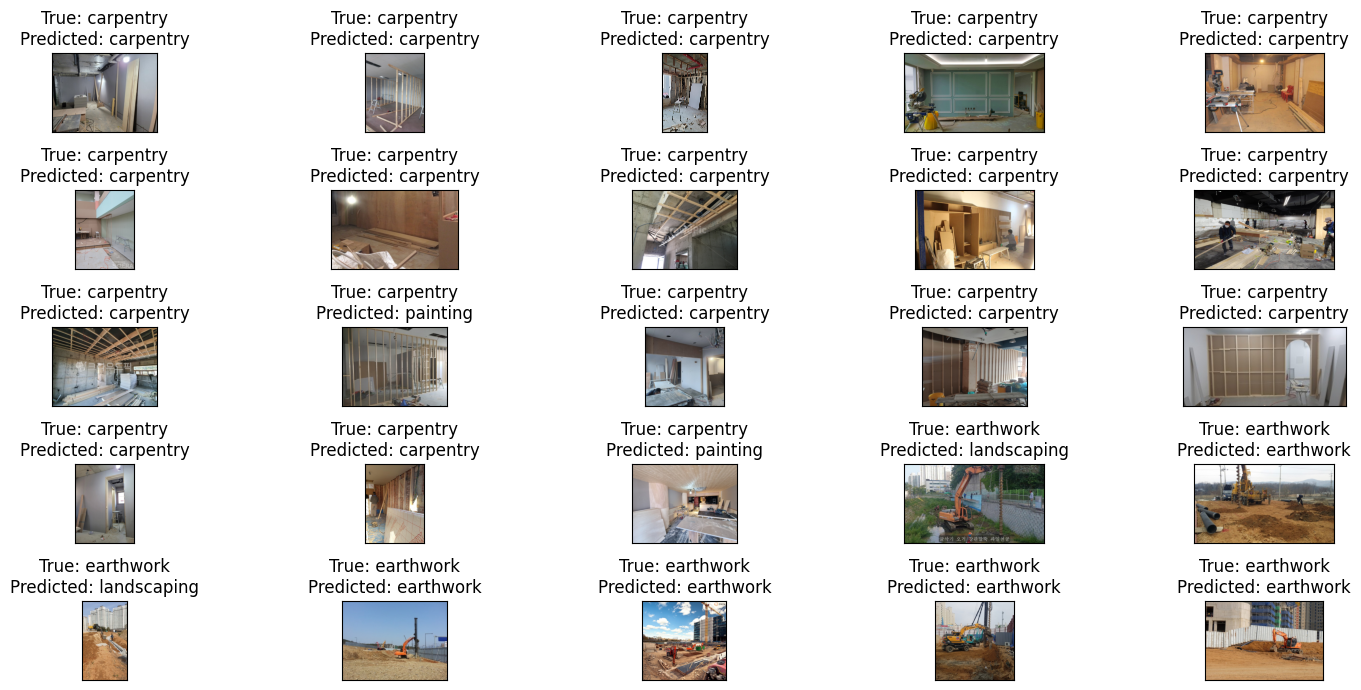

In [35]:
# Display 25 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred_final[i]}")
plt.tight_layout()
plt.show()

In [ ]:
model.save("saved_model.h5")

#
비교

In [ ]:
#landscaping 결과 값
pred_org[[index for index, label in enumerate(labels_test) if np.array_equal(label, np.array([0, 0, 1, 0, 0, 0]))]]

In [ ]:
vector.index(1)

In [165]:
vector=[0, 0, 0, 1, 0, 0]
ind=[index for index, label in enumerate(labels_test) if np.array_equal(label, np.array(vector))]
category_gt=labels[vector.index(1)]
category_pd=[]
category_pd_org=[]
filename=[]
pred_gt=[]
pred_pd=[]
pred_gt_org=[]
pred_pd_org=[]
for i in ind:
    category_pd_org.append(pred_org_final[i])
    category_pd.append(pred_final[i])
    filename.append(test_images.filenames[i])
    pred_gt.append(pred[i,vector.index(1)])
    pred_pd.append(np.max(pred[i]))
    pred_gt_org.append(pred_org[i,vector.index(1)])
    pred_pd_org.append(np.max(pred_org[i]))

In [166]:
df={'index':ind,'filename':filename,'category_gt':category_gt,'category_pd_org':category_pd_org, 'category_pd':category_pd,
    'org_pd':pred_pd_org, 'org_gt':pred_gt_org, 'propose_pd':pred_pd,'propose_gt':pred_gt}

In [167]:
df=pd.DataFrame(df)

In [168]:
df.to_csv('masonry.csv')

# 시각화

In [ ]:
path=test_df.Filepath.iloc[28]
display(Image(filename=path, width=600))

In [ ]:
#객체탐지 결과
path=test_df.Filepath.iloc[15]
filename = '/content/runs/detect/predict/'+os.path.basename(path)
display(Image(filename=filename, width=600))

In [ ]:
df=pd.DataFrame(lst_test[34][0], index=tfidf.columns).transpose().sum().sum()

In [ ]:
df

In [ ]:
total = df.sum().sum()

In [ ]:
a=pd.DataFrame(test_df.Label)

In [ ]:
labels_tp = {v: k for k, v in labels.items()}

In [ ]:
a['predict_org'] = pred_org_final
a['predict'] = pred_final
a['result'] = 0
a['object_num']=0
a=a.reset_index(drop=True)

In [ ]:
for i in range(93):
  a['object_num'][i]= pd.DataFrame(lst_test[i][0], index=tfidf.columns).transpose().sum().sum()
  if pred[i][labels_tp[a['Label'][i]]]>pred_org[i][labels_tp[a['Label'][i]]]:
    a['result'][i]=1
  else:
    pass

In [ ]:
a

In [ ]:
a.to_csv('a.csv', index=False)

In [ ]:
pred[12]

In [ ]:
pred_org[12]

In [ ]:
labels

# 새 섹션

In [ ]:
def check_feature_org(num_layer, id):
  object_data=object_test[id].reshape(1, 84)
  feature_layer = model.get_layer(num_layer)
  feature_layer_org = model_org.get_layer(num_layer)
  # Create a new model that will output the feature maps from the chosen layer
  feature_map_model = Model(inputs=model.input, outputs=feature_layer.output)
  feature_map_model_org = Model(inputs=model_org.input, outputs=feature_layer_org.output)
  # Load and preprocess your image data
  input_img=test_df.Filepath.iloc[id]
  img = tf.keras.preprocessing.image.load_img(input_img, target_size=(224, 224))
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  #img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
  img_array = tf.expand_dims(img_array, axis=0)
  # Get the feature maps for your image
  feature_map = feature_map_model.predict([img_array, object_data])[0]
  feature_map_org = feature_map_model_org.predict(img_array)[0]
  print(feature_map.shape)

  plt.figure(figsize=(10, 10))
  for i in range(feature_map_org.shape[-1]):
      plt.subplot((feature_map_org.shape[-1]//10)+1, 10, i + 1)  # Assumes 192 channels, adjust the subplot arrangement based on the actual number of channels
      plt.imshow(feature_map_org[:, :, i], cmap='viridis')  # Choose a suitable colormap
      plt.axis('off')
  plt.show()

In [ ]:
def check_feature(num_layer, id):
  object_data=object_test[id].reshape(1, 84)
  feature_layer = model.get_layer(num_layer)
  #feature_layer_org = model_org.get_layer(num_layer)
  # Create a new model that will output the feature maps from the chosen layer
  feature_map_model = Model(inputs=model.input, outputs=feature_layer.output)
  #feature_map_model_org = Model(inputs=model_org.input, outputs=feature_layer_org.output)
  # Load and preprocess your image data
  input_img=test_df.Filepath.iloc[id]
  img = tf.keras.preprocessing.image.load_img(input_img, target_size=(224, 224))
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  #img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
  img_array = tf.expand_dims(img_array, axis=0)
  # Get the feature maps for your image
  feature_map = feature_map_model.predict([img_array, object_data])[0]
  #feature_map_org = feature_map_model_org.predict(img_array)[0]
  print(feature_map.shape)
  #print(feature_map.shape[0]*25/56, feature_map.shape[3])
        #*25/56,((feature_map.shape[3]//10)+1)*feature_map.shape[0]/112*5)
  #print(((feature_map.shape[2]//10)+1))

  plt.figure(figsize=(int(feature_map.shape[0]*25/56),int(((feature_map.shape[2]//10)+1)*feature_map.shape[0]/112*5)))
  for i in range(feature_map.shape[-1]):
      plt.subplot((feature_map.shape[-1]//10)+1, 10, i + 1)  # Assumes 192 channels, adjust the subplot arrangement based on the actual number of channels
      plt.imshow(feature_map[:, :, i], cmap='viridis')  # Choose a suitable colormap
      plt.axis('off')
  plt.show()

In [ ]:
plt.figure()
plt.imshow(tf.keras.preprocessing.image.load_img(test_df.Filepath.iloc[13], target_size=(224, 224)))
plt.colorbar()
plt.show()

In [ ]:
check_feature('Conv1', 41)

In [ ]:
check_feature('Conv1', 4)

In [ ]:
def check_feature_down(num_layer, id):
  object_data=object_test[id].reshape(1, 84)
  feature_layer = model.get_layer(num_layer)
  #feature_layer_org = model_org.get_layer(num_layer)
  # Create a new model that will output the feature maps from the chosen layer
  feature_map_model = Model(inputs=model.input, outputs=feature_layer.output)
  #feature_map_model_org = Model(inputs=model_org.input, outputs=feature_layer_org.output)
  # Load and preprocess your image data
  input_img=test_df.Filepath.iloc[id]
  img = tf.keras.preprocessing.image.load_img(input_img, target_size=(224, 224))
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  #img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
  img_array = tf.expand_dims(img_array, axis=0)
  # Get the feature maps for your image
  feature_map = feature_map_model.predict([img_array, object_data])[0]
  #feature_map_org = feature_map_model_org.predict(img_array)[0]
  #print(feature_map.shape)
  #print(feature_map.shape[0]*25/56, feature_map.shape[3])
        #*25/56,((feature_map.shape[3]//10)+1)*feature_map.shape[0]/112*5)
  #print(((feature_map.shape[2]//10)+1))

  plt.figure(figsize=(int(feature_map.shape[0]*25/56),int(((feature_map.shape[2]//10)+1)*feature_map.shape[0]/112*5)))
  for i in range(feature_map.shape[-1]):
      plt.subplot((feature_map.shape[-1]//10)+1, 10, i + 1)  # Assumes 192 channels, adjust the subplot arrangement based on the actual number of channels
      plt.imshow(feature_map[:, :, i], cmap='viridis')  # Choose a suitable colormap
      plt.axis('off')
  #plt.show()
  plt.savefig('/content/{}.png'.format(id))

In [ ]:
for index in range(93):
  check_feature_down('block_2_depthwise', index)

In [ ]:
import os
import zipfile

# Replace the list below with the actual file paths of your images.
image_file_paths = []
for i in range(93):
  image_file_paths.append('/content/{}.png'.format(i))

# Create a directory to save the compressed images (if it doesn't exist).
output_directory = 'images1'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Define the name of the ZIP file to create.
zip_filename = 'images1.zip'

# Compress the images and add them to the ZIP file.
with zipfile.ZipFile(os.path.join(output_directory, zip_filename), 'w') as zipf:
    for idx, image_path in enumerate(image_file_paths):
        # Extract the filename from the image path
        image_name = os.path.basename(image_path)

        # Add the compressed image to the ZIP file
        zipf.write(image_path, image_name)

        # Delete the temporary compressed image file (optional)
        os.remove(image_path)


In [ ]:
check_feature('block_16_depthwise', 2)